In [1]:
from pathlib import Path
import torch
import json
import numpy as np
from scipy.spatial import distance
from models.DAE import Decoder
import pandas as pd
import networkx as nx
from utils import to_img, get_device
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import PIL.Image as Image
import random

In [2]:
###Model loading ###

def load_config(base_path, config_path=None):
    if config_path is None:
        config_path = Path(base_path) / Path('config.json')
    with config_path.open() as f:
        config = json.load(f)
    return config

def load_model(base_path, model_path=None):
    if model_path is None:
        model_path = Path(base_path) / Path('model.pth')
    config = load_config(base_path)
    dims= config['dims']
    device = get_device()
    state_dict = torch.load(model_path, map_location=torch.device(device))
    decoder = Decoder(dims)
    decoder.load_state_dict(state_dict['decoder'])
    decoder.to(device)
    return decoder

def load_encoding(base_path, encoding_path=None):
    if encoding_path is None:
        encoding_path = Path(base_path) / Path('encoding.json')
    with encoding_path.open() as f:
        points_data = json.load(f)
    return points_data


In [12]:
###Model evaluation ###

def describe(config, model, encoding):
    print("*"*80)
    print("model is:")
    print(model)
    print("*"*80)

    print("*"*80)
    print("model was trained with:")
    print(json.dumps(config, indent=4, sort_keys=True))
    print("*"*80)
    
    print('comparing original images (not noised) to their corresponding autoencoder output. mse is calculated in rgb space')
    print("MSE:{}".format(encoding_mse(encoding, model)))
    print("*"*80)
    
    points=[p['z'] for p in encoding]
    print("first image can be found at found at {}".format(encoding[0]['path']))
    print('there are {} points encoded'.format(pd.DataFrame(points).shape[0]))
    print('each point has {} dimensions'.format(len(points[0])))
    print('first 5 points are:')
    print(pd.DataFrame(points).head())
    print("*****************")
    

def latent_to_img(vector, decoder):
    device = get_device()
    reshaped = torch.from_numpy(np.expand_dims(np.array(vector), axis=0)).type(torch.FloatTensor).to(device)
    original = decoder(reshaped)
    img = to_img(original)[0].permute(1,2,0).detach().numpy()
    return img

def encoding_mse(encoding, model, sample_size=100):
    ### comparing original images (not noised) to their corresponding autoencoder output. mse is calculated in rgb space###
    ### sampling is done for performace ###
    sampled_encoding = random.sample(encoding, sample_size)
    points = [p['z'] for p in sampled_encoding]
    paths = [p['path'] for p in sampled_encoding]
    total = 0.0
    for point, path in zip(points, paths):
        true_img = np.asarray(Image.open(path))
        pred_img = Image.fromarray((latent_to_img(point, model) *255).astype(np.uint8), 'RGB')
        diff = true_img - pred_img
        total+=(diff**2).mean()
    return total / len(points)

def show_true_vs_decoded(encoding,model, idx):
    p = encoding[0]['z']
    path = encoding[0]['path']
    
    true_img=np.asarray(Image.open(path))
    pred_img = Image.fromarray((latent_to_img(p, model) *255).astype(np.uint8), 'RGB')

    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(true_img)
    ax1.set_title('original')
    ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(pred_img)
    ax2.set_title('decoded')
    ax2.axis('off');
    plt.show()


In [50]:
### Graph utils ###

def add_edges(G, knn_graph, distances, k):
    n = G.number_of_nodes()
    deg = G.degree[0]
    for u in range(n):
        for v in range(deg, k):
            neighbor = knn_graph[u][v]
            G.add_edge(u, neighbor, weight=distances[u][neighbor])
    return G


def add_nodes(G, points):
    for u in np.arange(len(points)):
        G.add_node(u, pos=tuple(points[u]))

def get_sorted_nn_graph(distances):
    knn_graph = np.argsort(distances, axis=1, kind='stable')[:, 1:]  # node is closest to itself always
    return knn_graph


def get_graph(points, dist_type='euclidean', k=None, start_k=2, max_k=100):
    distances = distance.cdist(points, points, dist_type)
    knn_graph = get_sorted_nn_graph(distances)
    G = nx.Graph()
    add_nodes(G, points)
    if k is None:
        for i in range(start_k, max_k):
            add_edges(G, knn_graph, distances, i)
            if nx.is_connected(G):
                return G
    else:
        add_edges(G, knn_graph, distances, k)
        return G
    return None # couldnt find connection


def get_most_distant_points(points, dist_type='euclidean'):
    distances = distance.cdist(points, points, dist_type)
    I = np.unravel_index(distances.argmax(), distances.shape)
    return I


def get_shortest_path_graph(G, source, destination):
    path = nx.dijkstra_path(G, source, destination, weight='weight')
    G2= nx.Graph()
    G2.add_nodes_from(G.nodes(data=True))
    for i in range(len(path)-1):
        data = G.get_edge_data(path[i], path[i+1])
        G2.add_edge(path[i], path[i+1], weight=data['weight'])
    return G2

def display_path_graph(G, path):
    G2= nx.Graph()
    G2.add_nodes_from(G.nodes(data=True))
    for i in range(len(path)-1):
        G2.add_edge(path[i], path[i+1])
    display_latent_space(G2, with_edges=True)

def display_latent_space(G, with_edges=False, view_params=None):
    if view_params is None:
        view_params = (50, 70)
    pos= nx.get_node_attributes(G,'pos')
    if len(points[0])==2:
        if not with_edges:
            nx.draw_networkx_nodes(G, pos, node_size=5)
        else:
            nx.draw(G, pos, node_size=5)
        plt.show()
    if len(points[0])==3:
        %matplotlib inline 
        pos = nx.get_node_attributes(G, 'pos')
        angle = 0
        with plt.style.context(('ggplot')):

            fig = plt.figure(figsize=(10,7))
            ax = Axes3D(fig)

            # Loop on the pos dictionary to extract the x,y,z coordinates of each node

            for key, value in pos.items():
                xi = value[0]
                yi = value[1]
                zi = value[2]
                #rint('here')
                ax.scatter(xi, yi, zi, s=1, c='blue')
            
            if with_edges:
                for i,j in enumerate(G2.edges()):
                    x = np.array((pos[j[0]][0], pos[j[1]][0]))
                    y = np.array((pos[j[0]][1], pos[j[1]][1]))
                    z = np.array((pos[j[0]][2], pos[j[1]][2]))
                    ax.plot(x, y, z, c='black', alpha=0.5)
        
        # Set the initial view
        ax.view_init(view_params[0], view_params[1])
        # Hide the axes
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        print('wait a bit for 3d graph to be displayed')
        plt.show()

        
def display_3d_convex_hull():
    if len(points[0])==3:
        from scipy.spatial import ConvexHull
        pts = np.array(points)

        hull = ConvexHull(pts)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        # Plot defining corner points
        #ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

        # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

        # Make axis label
        for i in ["x", "y", "z"]:
            eval("ax.set_{:s}label('{:s}')".format(i, i))

        plt.show()
    else:
        raise NotImplemented('not implemented convex hull for 2d')

        
def display_neighbors_for_latent_image(encoding, model, idx):
    points = [p['z'] for p in encoding]
    vector = encoding[idx]['z']
    path = encoding[idx]['path']
    original = latent_to_img(vector, model)
    
    fig = plt.figure()
    plt.axis('off')
    num_axes = min(k, 5)
    ax1 = fig.add_subplot(1,num_axes+2,1)
    ax1.axis('off')
    ax1.set_title('decoded')
    ax1.imshow(original)

    ax2 = fig.add_subplot(1,num_axes+2, 2)
    ax2.axis('off')
    ax2.imshow(Image.open(path))
    ax2.set_title('original')

    for i,neighbors in enumerate(list(G.neighbors(idx))[:num_axes], start=3):
        ax = fig.add_subplot(1,num_axes+2,i)
        ax.set_title('n'+ str(i-2))
        img = latent_to_img(points[i], model)
        ax.axis('off')
        ax.imshow(img)
    plt.show()

        

In [21]:
path = 'benchmarks/model2'
config = load_config(path)
model = load_model(path)
encoding = load_encoding(path)
points = [p['z'] for p in encoding]
describe(config, model, encoding)


********************************************************************************
model is:
Decoder(
  (fc1): Linear(in_features=2, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (deconv2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (deconv3): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (tanh): Tanh()
)
********************************************************************************
********************************************************************************
model was trained with:
{
    "IMAGES_PATH": "images2d",
    "batch_size": 8,
    "criterion_weight": 1,
    "dims": 2,
    "loss_network_weight": 0,
    "lr": 0.01,
    "noise": 0.2,
    "noise_types": "normal",
    "num_epochs": 600,
    "out_channels": 64,
    "step_size": 150,
    "wd": 1e-05
}
********************************************************************************
comparing 

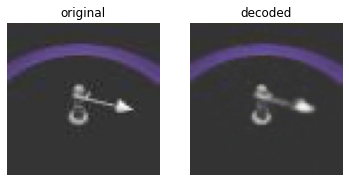

In [22]:
show_true_vs_decoded(encoding, model, idx=0)


In [23]:
G = get_graph(points,dist_type='euclidean',start_k=1, max_k=1000)
k = max(deg for deg in G.degree)[1]
print('minimal degree for graph to be connected is {}'.format(k))

minimal degree for graph to be connected is 4


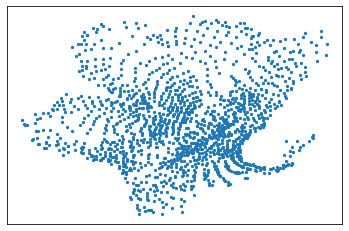

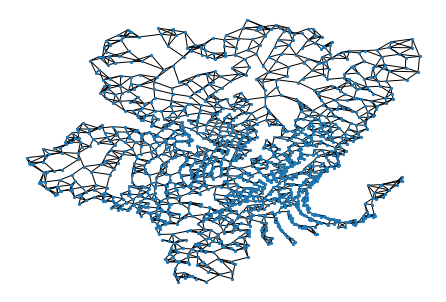

In [42]:
display_latent_space(G, with_edges=False)
display_latent_space(G, with_edges=True)

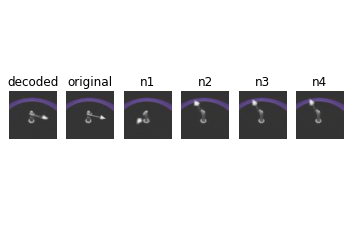

In [41]:
display_neighbors_for_latent_image(encoding,model, 0)

most distant points are at indexes (182, 220)


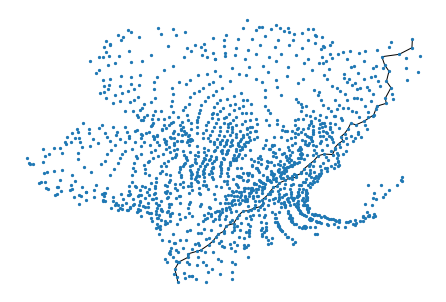

In [44]:
## shortest_path for two most distant points ##
source, dest = get_most_distant_points(points, dist_type='euclidean')


print("most distant points are at indexes {}".format(I))

G2 = get_shortest_path_graph(G, source, dest)
display_latent_space(G2, with_edges=True)


[-1.0756421089172363, -9.822985649108887] [-1.0756421089172363, -9.822985649108887]
[9.151637077331543, 7.5126776695251465] [9.151637077331543, 7.5126776695251465]


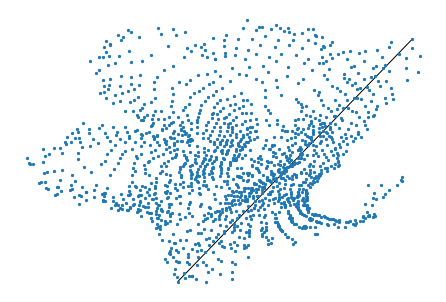

In [71]:
n_images=len(path)*2+1 #assuming number of images is k*len(path) + 1
sampled_path = [path[0], path[-1]]

def generate_extra_points(u, v, n_points):
    u = np.array(u)
    v = np.array(v)
    alphas = np.linspace(0, 1, n_points)[1:-1]
    points = []
    for alpha in alphas:
        points.append((1-alpha) *u + (alpha)*v)
    return points


interpolation_path = []
for i in range(len(sampled_path)-1):
    images_to_generate = n_images // len(sampled_path) - 1
    u = points[sampled_path[i]]
    v = points[sampled_path[i+1]]
    new_points = generate_extra_points(u,v, images_to_generate)
    if i==0:
        to_add = [u]+new_points+[v]
    else:
        to_add = new_points+[v]
    interpolation_path.extend(to_add)
    
print(interpolation_path[0], points[sampled_path[0]])
print(interpolation_path[-1], points[sampled_path[-1]])
display_path_graph(G, sampled_path)


<Figure size 432x288 with 0 Axes>

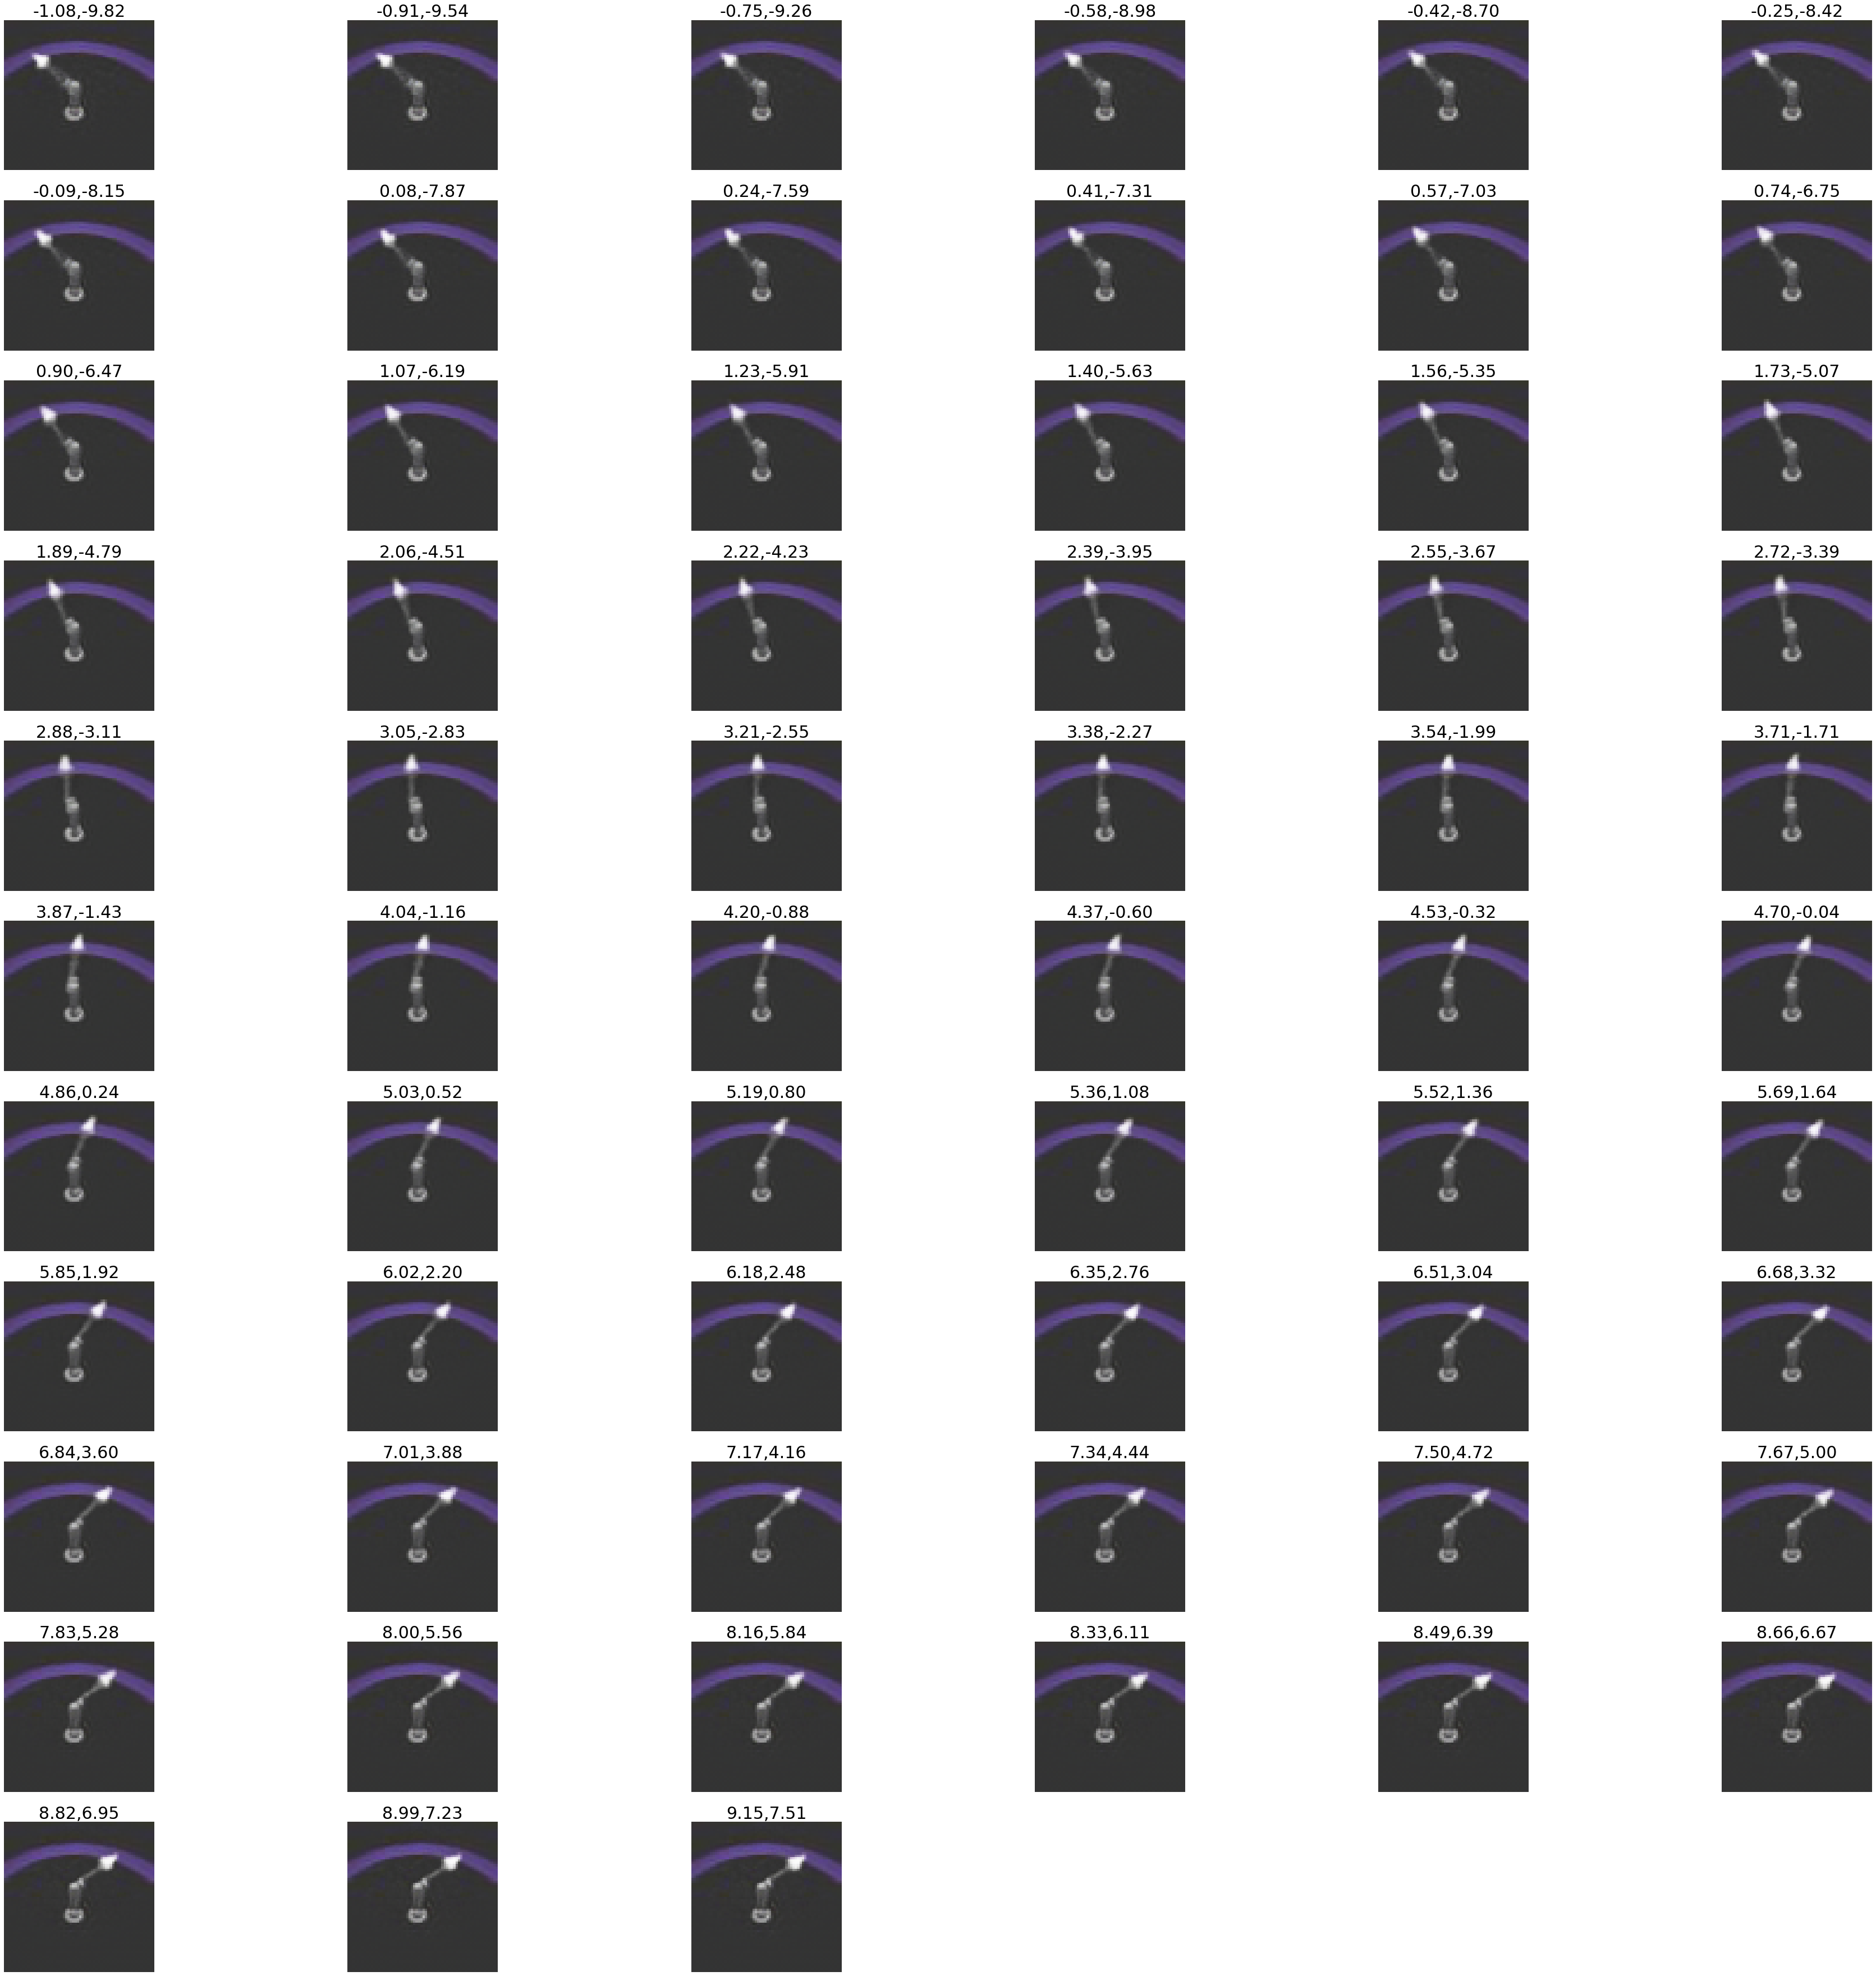

In [74]:
fig = plt.figure()

fig=plt.figure(figsize=(64, 64))
columns = 6
rows = np.ceil(len(interpolation_path)/columns)
for i in range(1, len(interpolation_path) +1):
    img = latent_to_img(interpolation_path[i-1], model)
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    ax.set_title("{:.2f},{:.2f}".format(float(interpolation_path[i-1][0]), float(interpolation_path[i-1][1])), fontsize=30)
    ax.imshow(img)
plt.show()
    

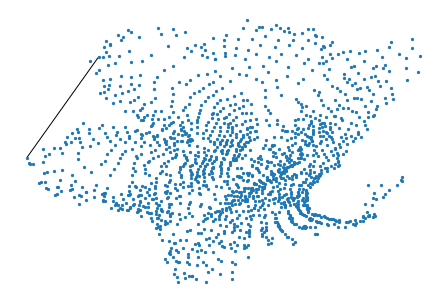

<Figure size 432x288 with 0 Axes>

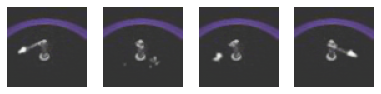

In [361]:
#demonstrating naive linear interpolation in latent space artifacts, with benchmarks/model2


nodes = list(G.nodes(data=True))
rightmost_nodes = sorted(nodes, key=lambda x:-x[1]['pos'][0])[-70:]
top_nodes = sorted(rightmost_nodes, key=lambda x:x[1]['pos'][1])

bottom_node = rightmost_nodes[-1][0]
top_node = top_nodes[-1][0]

G3= nx.Graph()
G3.add_nodes_from(G.nodes(data=True))

G3.add_edge(bottom_node, top_node)
nx.draw(G3, pos, node_size=5)
u = points[bottom_node]
v = points[top_node]
middle = generate_extra_points(u,v,4)

pos = nx.get_node_attributes(G3,'pos')
interpolation_path = [u]+ middle + [v]

fig = plt.figure()

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 6
rows = np.ceil(len(interpolation_path)/columns)
for i in range(1, len(interpolation_path) +1):
    img = latent_to_img(interpolation_path[i-1])
    
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    ax.imshow(img)
plt.show()


<Figure size 432x288 with 0 Axes>

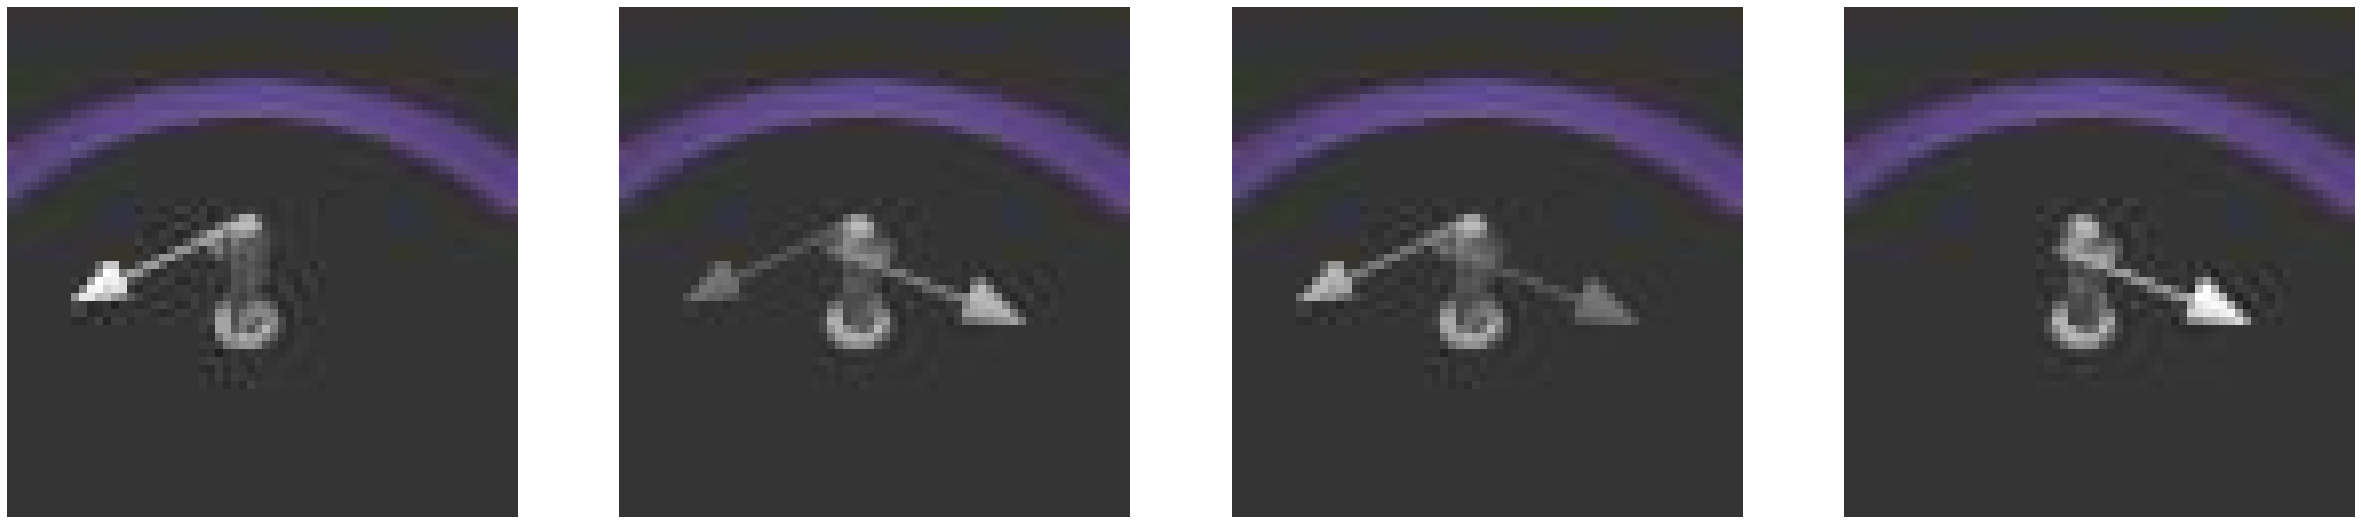

In [362]:
#demonstrating naive linear interpolation in pixel domain, with 2 degrees of freedom images

import PIL.Image as Image
u_path = points_data[bottom_node]['path']
v_path = points_data[top_node]['path']

u_img=np.asarray(Image.open(u_path))
v_img = np.asarray(Image.open(v_path))

images = generate_extra_points(u_img, v_img, 4)
interpolation = [u_img] + images + [v_img]

fig = plt.figure()

w=10
h=10
fig=plt.figure(figsize=(64,64))
columns = 6
for i in range(1, len(interpolation) +1):
    img = interpolation[i-1].astype(np.uint8)
    ax = fig.add_subplot(rows, columns, i)
    ax.axis('off')
    #ax.set_aspect('equal')


    ax.imshow(img)
#plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
